In [14]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# 파일 경로
desktop_path = 'C:/Users/user/Desktop/DBGAPS/Data'
file_name = '2024-07-24.xlsx'
file_path = f'{desktop_path}/{file_name}'

# 파일을 DataFrame으로 로드
adjusted_opening_prices_df = pd.read_excel(file_path, sheet_name='Sheet1')

# 날짜 열을 인덱스로 설정
adjusted_opening_prices_df.set_index('date', inplace=True)
adjusted_opening_prices_df.index = pd.to_datetime(adjusted_opening_prices_df.index)


# 수익률 계산
returns_df = adjusted_opening_prices_df.pct_change().dropna()

# 무위험 이자율
risk_free_rate = returns_df['riskfreerate'].mean()

# 각 자산의 샤프 비율 계산
excess_returns_df = returns_df.subtract(risk_free_rate, axis=0)
sharpe_ratios = excess_returns_df.mean() / excess_returns_df.std()

# 상관 행렬 및 공분산 행렬 계산
correlation_df = excess_returns_df.corr()
cov_matrix_df = excess_returns_df.cov()

# 기본 자산별 경계 설정 (최소 0, 최대 1)
labels = returns_df.columns.tolist()
bounds = {label: (0, 1) for label in labels}

# 개별 자산별 경계 예시 (필요 시 수정)
individual_bounds = {
    'A138230': (0.00, 0.20),
    'A114800': (0.00, 0.20),
    'A132030': (0.00, 0.15),
    'A130680': (0.00, 0.15),
    'A192090': (0.00, 0.20),
    'A136340': (0.00, 0.40)
    
}

# 개별 경계를 bounds에 적용
for asset, bound in individual_bounds.items():
    bounds[asset] = bound

# 계층적 클러스터링을 사용하여 자산 클러스터 분류
def hierarchical_clustering(corr):
    dist = np.sqrt((1 - corr) / 2)
    linkage_matrix = linkage(squareform(dist), method='single')
    return linkage_matrix

# Quasi-Diagonalization
def get_quasi_diag(linkage_matrix):
    sortIx = [int(linkage_matrix[-1, 0]), int(linkage_matrix[-1, 1])]
    numItems = int(linkage_matrix[-1, 3])  # 클러스터의 항목 수
    while max(sortIx) >= numItems:
        new_sortIx = []
        for i in range(0, len(sortIx), 2):
            if sortIx[i] >= numItems:
                new_sortIx.extend([int(linkage_matrix[sortIx[i] - numItems, 0]), int(linkage_matrix[sortIx[i] - numItems, 1])])
            else:
                new_sortIx.append(sortIx[i])
            if i + 1 < len(sortIx):
                if sortIx[i + 1] >= numItems:
                    new_sortIx.extend([int(linkage_matrix[sortIx[i + 1] - numItems, 0]), int(linkage_matrix[sortIx[i + 1] - numItems, 1])])
                else:
                    new_sortIx.append(sortIx[i + 1])
        sortIx = new_sortIx
    return sortIx

# getClusterVar 함수
def get_cluster_var(cov, cItems):
    cov_ = cov.loc[cItems, cItems]  # 하위 집합의 공분산 행렬
    ivp = 1. / np.diag(cov_)
    ivp /= ivp.sum()
    w_ = np.dot(ivp, cov_)
    return np.dot(w_, ivp)

# HRP 알고리즘 함수
def get_rec_bipart(cov, sortIx, bounds):
    w = pd.Series(1, index=cov.index)  # 초기 가중치를 1로 설정
    clItems = [cov.index.tolist()]  # 모든 자산을 하나의 클러스터로 초기화
    while len(clItems) > 0:
        new_clItems = []
        for items in clItems:
            if len(items) > 1:
                # 하위 집합을 두 개의 클러스터로 분할
                half = len(items) // 2
                cItems0 = items[:half]
                cItems1 = items[half:]

                cVar0 = get_cluster_var(cov, cItems0)
                cVar1 = get_cluster_var(cov, cItems1)
                alpha = 1 - cVar0 / (cVar0 + cVar1)
                w[cItems0] *= alpha
                w[cItems1] *= 1 - alpha

                # 자산별 경계를 적용
                for asset in cItems0:
                    w[asset] = np.clip(w[asset], bounds[asset][0], bounds[asset][1])
                for asset in cItems1:
                    w[asset] = np.clip(w[asset], bounds[asset][0], bounds[asset][1])

                new_clItems.extend([cItems0, cItems1])
        clItems = new_clItems

    # 가중치가 0~1 사이에 있는지 확인
    w = np.clip(w, 0, 1)

    # 가중치의 합을 1로 정규화
    w /= w.sum()
    return w

# 상관 행렬로부터 자산 클러스터 분류
linkage_matrix = hierarchical_clustering(correlation_df)
sorted_indices = get_quasi_diag(linkage_matrix)

# 정렬된 인덱스와 매핑하여 인덱스를 변환
sorted_labels = [correlation_df.index[i] for i in sorted_indices]

# 재배열된 상관 행렬
sorted_correlation_matrix = correlation_df.loc[sorted_labels, sorted_labels]

# 가중치 계산
hrp_weights = get_rec_bipart(pd.DataFrame(sorted_correlation_matrix, index=sorted_labels, columns=sorted_labels), sorted_labels, bounds)

# 결과 출력
print("HRP Weights:")
print(hrp_weights)


HRP Weights:
A138230         0.045141
A114800         0.045141
A192090         0.069673
A130730         0.288021
A132030         0.032711
A130680         0.032711
A136340         0.053947
A148070         0.111505
A139660         0.049994
A232080         0.049994
A182490         0.045073
A238720         0.045073
A195930         0.034339
A069500         0.034339
A143850         0.031170
riskfreerate    0.031170
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_8792\4227241715.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.82678078 0.82678078 0.82678078 0.82678078 0.82678078 0.82678078
 0.82678078 0.82678078]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[cItems0] *= alpha


A130730	A138230	A139660	A114800	A130680	A132030	A182490	A136340	A148070	A192090	A238720	A195930	A143850	A232080	A069500
단기	미국달러 선물	미국달러인버스		WTI	골드선물	단기 선진 하일일드	(KBSTAR 중기우량회사채)	(KOSEF 국고채10년)	(TIGER 차이나CSI300)	(ACE 일본Nikkei225(H))	(TIGER 유로스탁스50(합성 H))	S&P500	(TIGER 코스닥150)	(KODEX 200)


In [16]:
# 변동성과 평균 수익률 계산
volatility = returns_df.std()
mean_return = returns_df.mean()


print("\nVolatility:")
print(volatility*100)
print("\nMean Return:")
print(mean_return*100)


Volatility:
A130730         0.062595
A138230         1.089698
A139660         1.103826
A114800         2.402096
A130680         4.446822
A132030         1.922233
A182490         0.877521
A136340         0.195048
A148070         0.751568
A192090         2.513779
A238720         2.686000
A195930         2.692061
A143850         2.322407
A232080         3.213010
A069500         2.369706
riskfreerate    0.587056
dtype: float64

Mean Return:
A130730         0.033699
A138230         0.070304
A139660        -0.040316
A114800        -0.136183
A130680         0.162393
A132030         0.112760
A182490         0.077921
A136340         0.039454
A148070         0.018045
A192090         0.092884
A238720         0.255641
A195930         0.177622
A143850         0.248991
A232080         0.123510
A069500         0.173974
riskfreerate    0.064526
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_8792\2416163109.py:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, 'single')


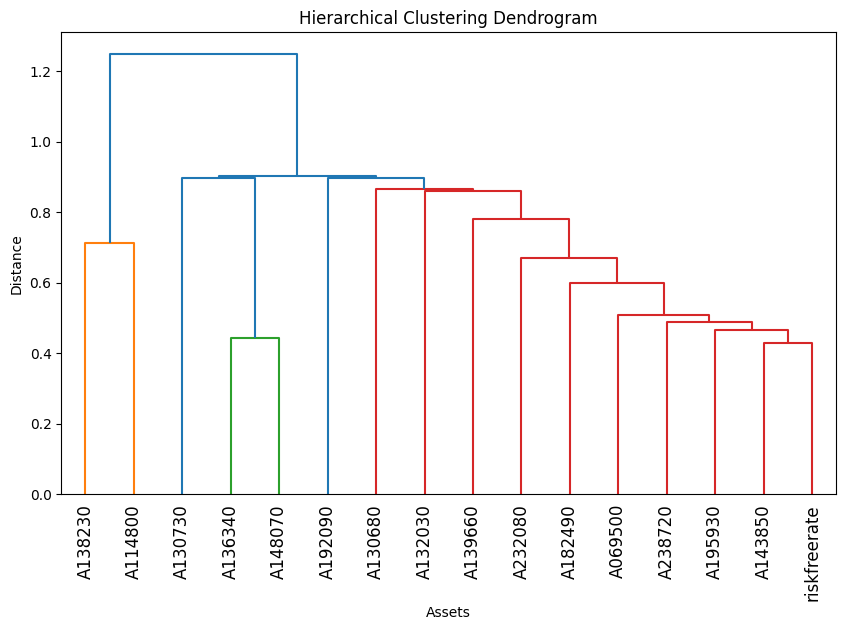

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram,leaves_list

def compute_hrp_weights_with_objective(correlation_matrix):
    def compute_distance_matrix(correlation_matrix):
        return np.sqrt((1 - correlation_matrix) / 2)

    distance_matrix = compute_distance_matrix(correlation_matrix)
    
    # scipy의 linkage 함수를 사용하여 계층적 클러스터링 수행
    Z = linkage(distance_matrix, 'single')
    
    return Z



# Use the correlation_df as the correlation matrix
correlation_matrix = correlation_df.values

# Compute HRP linkage matrix
Z = compute_hrp_weights_with_objective(correlation_matrix)




# 덴드로그램 시각화
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=correlation_df.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Assets")
plt.ylabel("Distance")
plt.show()

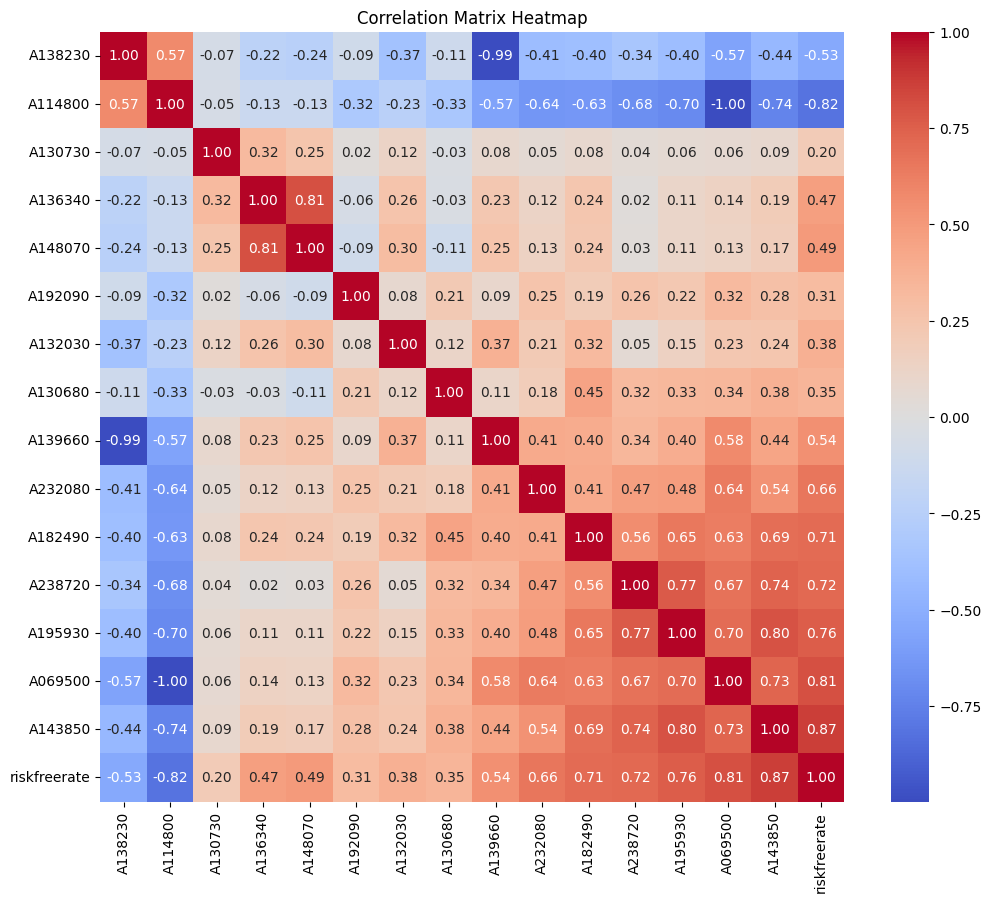

In [22]:
import seaborn as sns
data=sorted_correlation_matrix

# Corresponding column and row labels
labels = ['A138230', 'A114800', 'A130730', 'A136340', 'A148070', 'A192090', 'A132030', 'A130680', 'A139660', 'A232080', 'A182490', 'A238720', 'A195930', 'A069500', 'A143850', 'riskfreerate']

# Create DataFrame
df = pd.DataFrame(data, columns=labels, index=labels)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_8792\652772869.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_resampled = returns.resample(freq).apply(lambda x: (1 + x).prod() - 1)



HRP로 최적화된 포트폴리오 일간 수익률 (최근 3년):
date
2019-06-30    0.006188
2019-07-31    0.003870
2019-08-31   -0.004433
2019-09-30    0.003363
2019-10-31    0.007279
Freq: ME, dtype: float64


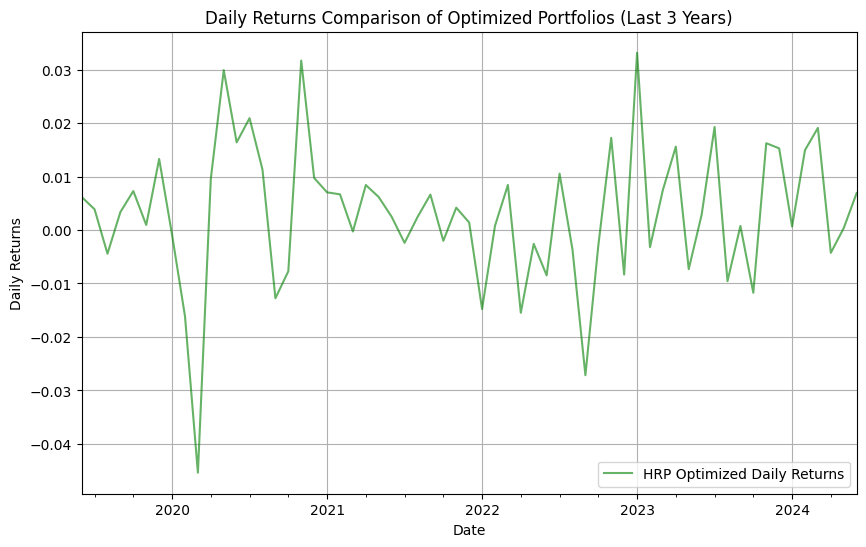

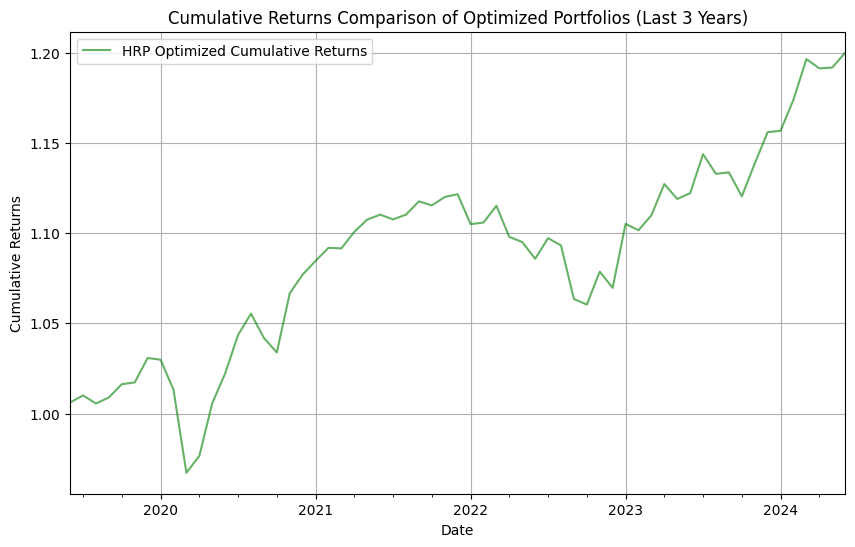

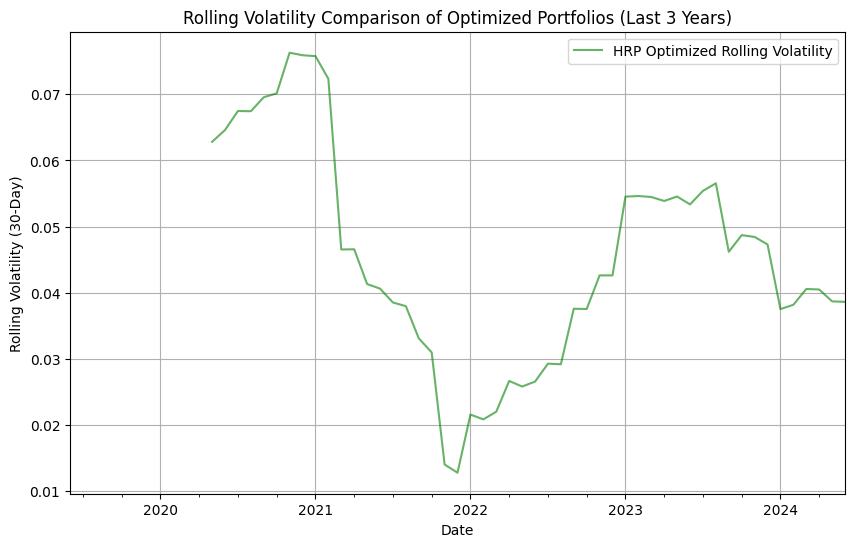

In [26]:
def backtest_portfolio(returns, weights, freq='M'):
    """
    주어진 가중치를 사용하여 포트폴리오의 백테스팅을 수행합니다.
    
    :param returns: 자산의 일간 수익률 (DataFrame)
    :param weights: 포트폴리오의 자산별 가중치 (Series)
    :param freq: 수익률 계산 빈도 (기본값: 'M' - 월간)
    :return: 포트폴리오의 수익률 (Series), 포트폴리오의 누적 수익률 (Series), 포트폴리오의 변동성 (Series)
    """
    # 리샘플링하여 빈도에 맞춘 수익률 계산
    returns_resampled = returns.resample(freq).apply(lambda x: (1 + x).prod() - 1)
    
    # 포트폴리오의 수익률 계산
    portfolio_returns = (returns_resampled * weights).sum(axis=1)
    
    # 포트폴리오의 누적 수익률 계산
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    # 포트폴리오의 변동성 계산 (rolling window로 계산)
    rolling_volatility = portfolio_returns.rolling(window=12).std() * np.sqrt(12)  # 월간 변동성
    
    return portfolio_returns, cumulative_returns, rolling_volatility

# 최근 3년 데이터만 추출
end_date = returns_df.index.max()
start_date = end_date - pd.DateOffset(years=5)
recent_returns_df = returns_df[start_date:end_date]

# 샤프 비율로 최적화된 가중치를 사용하여 최근 3년 동안 백테스팅 수행

portfolio_returns, cumulative_returns, rolling_volatility = backtest_portfolio(recent_returns_df, hrp_weights)


# 백테스팅 결과 출력
print("\nHRP로 최적화된 포트폴리오 일간 수익률 (최근 3년):")
print(portfolio_returns.head())

# 백테스팅 결과 시각화
# 두 가지 최적화 방법의 일간 수익률을 겹치는 그래프로 시각화
plt.figure(figsize=(10, 6))
portfolio_returns.plot(color='green', label='HRP Optimized Daily Returns', alpha=0.6)
plt.title('Daily Returns Comparison of Optimized Portfolios (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()

# 두 가지 최적화 방법의 누적 수익률을 겹치는 그래프로 시각화
plt.figure(figsize=(10, 6))
cumulative_returns.plot(color='green', label='HRP Optimized Cumulative Returns', alpha=0.6)
plt.title('Cumulative Returns Comparison of Optimized Portfolios (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# 두 가지 최적화 방법의 변동성을 겹치는 그래프로 시각화
plt.figure(figsize=(10, 6))
#sharpe_rolling_volatility.plot(color='blue', label='Sharpe Ratio Optimized Rolling Volatility')
rolling_volatility.plot(color='green', label='HRP Optimized Rolling Volatility', alpha=0.6)
plt.title('Rolling Volatility Comparison of Optimized Portfolios (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Rolling Volatility (30-Day)')
plt.legend()
plt.grid(True)
plt.show()
